# Equilibrating the System

## Overview

### Questions

* What is equilibration?
* How do I save simulation results?

### Objectives

* Explain the process of **equilibration**.
* Demonstrate using **GSD** to write the simulation **trajectory** to a file.
* Demonstrate best practices for move size tuning using **Before** and **And Triggers**.

## Boilerplate code

In [1]:
import hoomd
import math

In [5]:
fn = '00-introducing-HOOMD-blue/trajectory.gsd'
![ -e "$fn" ] && rm "$fn"

The `render` function in the next (hidden) cell will render a snapshot using **fresnel**.

<div class="alert alert-info">
    This is not intended as a full tutorial on <b>fresnel</b> - see the <a href="https://fresnel.readthedocs.io/">fresnel user documentation</a> if you would like to learn more.
</div>

In [2]:
import fresnel

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=430, h=430)

def render(snapshot):
    L = snapshot.configuration.box[0]
    vertices=[(-0.5, 0, 0),
               (0.5, 0, 0),
               (0, -0.5, 0),
               (0, 0.5, 0),
               (0, 0, -0.5),
               (0, 0, 0.5)]
    poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.ConvexPolyhedron(scene,
                                                 poly_info,
                                                 N=snapshot.particles.N)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.01, 0.74, 0.26]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.orientation[:] = snapshot.particles.orientation[:]
    geometry.outline_width = 0.01
    box = fresnel.geometry.Box(scene, snapshot.configuration.box, box_radius=.02)
    
    scene.lights = [fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
                    fresnel.light.Light(direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3)]
    scene.camera = fresnel.camera.orthographic(position=(0, 0, L+1),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L+1)
    scene.background_color = (1,1,1)
    return tracer.sample(scene, samples=1000)

## Equilibration

So far, this tutorial has placed *N* non-overlapping octahedra randomly in a box and then compressed it to a moderate packing fraction.
The resulting configuration of particles is valid, but strongly dependent on the path taken to create it.
There are many more **equilibrium** configurations in the set of possible configurations that do not depend on the path.
**Equilibrating** the system is the process of taking an artificially prepared state and running a simulation.
During the simulation run, the system will relax to **equilibrium**.
Initialize the **Simulation** first:

In [3]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu)
mc = hoomd.hpmc.integrate.ConvexPolyhedron(seed=2)
mc.shape['octahedron'] = dict(vertices=[(-0.5, 0, 0),
                                         (0.5, 0, 0),
                                         (0, -0.5, 0),
                                         (0, 0.5, 0),
                                         (0, 0, -0.5),
                                         (0, 0, 0.5)])
sim.operations.integrator = mc

The previous section of this tutorial wrote the compressed system to `compressed.gsd`.
Initialize the system **state** from this file:

In [4]:
sim.create_state_from_gsd(filename='compressed.gsd')

Here is what the compressed random initial state looks like:

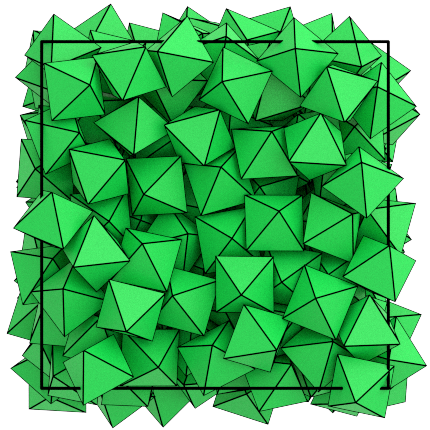

In [5]:
render(sim.state.snapshot)

## Writing simulation trajectories

Save the system **state** to a file periodically so that you can observe the equilibration process.
This tutorial previously used **GSD** files to store a single frame of the system **state** using either the **GSD** Python package or `GSD.write`.
The **GSD Writer** (another **operation**) will create a **GSD** file with many frames in a **trajectory**.

We use the `'xb'` mode to open the file to ensure that the file does not exist before opening it.
If the file does exist an error will be raised rather than overwriting or appending to the file.

In [6]:
gsd = hoomd.write.GSD(filename='trajectory.gsd',
                      trigger=hoomd.trigger.Periodic(10000),
                      mode='xb')
sim.operations.writers.append(gsd)

## Tuning the trial move size

The previous section used the **MoveSize** tuner regularly during compression to adjust `d` and `a` to achieve a target **acceptance ratio** while the system density changed rapidly.
Use it again during the equilibration run to ensure that HPMC is working optimally.

Move sizes should be tuned briefly at the beginning, then left constant for the duration of the run.
Changing the move size throughout the simulation run violates *detailed balance* and can lead to incorrect results.
Trigger the **tuner** every 100 steps but only for the first 5000 steps of the simulation by combining a **Periodic** and **Before** trigger with an **And** operation.
**Before** returns `True` for all **time steps** `t < value` and the **And** trigger returns `True` when all of its child triggers also return `True`.

In [7]:
tune = hoomd.hpmc.tune.MoveSize.scale_solver(moves=['a', 'd'],
                                             target=0.2,
                                             trigger=hoomd.trigger.And(
                                                 [hoomd.trigger.Periodic(100),
                                                  hoomd.trigger.Before(sim.timestep + 5000)]))
sim.operations.tuners.append(tune)

In [8]:
sim.run(5000)

Check the acceptance ratios over the next 100 steps to verify that the tuner achieved the target acceptance ratios:

In [9]:
sim.run(100)

In [10]:
rotate_moves = mc.rotate_moves
mc.rotate_moves[0] / sum(mc.rotate_moves)

0.20421552205471805

In [11]:
translate_moves = mc.translate_moves
mc.translate_moves[0] / sum(mc.translate_moves)

0.19965096686191125

## Equilibrating the system

To equilibrate the system, **run** the simulation.
The length of the run needed is strongly dependent on the particular model, the system size, the density, and many other factors.
Hard particle Monte Carlo self-assembly often takes tens of millions of time steps for systems with ~10,000 particles.
This system is much smaller, but it still takes approximately 1-2 million steps.

<div class="alert alert-warning">
This cell may require hours to complete.
</div>

In [12]:
sim.run(2e6)

Here is the final state of the system after the run.

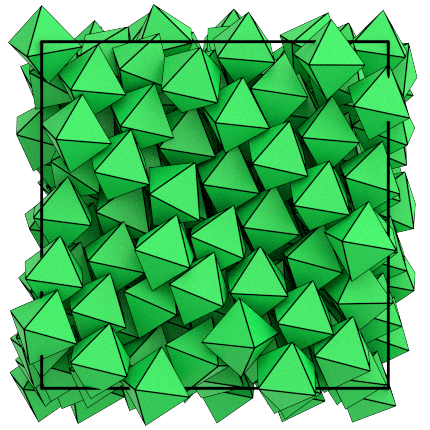

In [13]:
render(sim.state.snapshot)

Is the final **state** an **equilibrium state**?
The next section in this tutorial shows you how to analyze the **trajectory** and answer this question.

[Previous section](05-Compressing-the-System.ipynb). [Next section](07-Analyzing-Trajectories.ipynb).